# Tavsiye Sistemleri (Recommendation Systems)
- Kullanıcılara bazı teknikleri kullanarak ürün veya hizmet önermek.
- Tavsiye sistemlerinde genel amacımız, bol olan içerik, hizmet vb. durumları filtrelemektir.
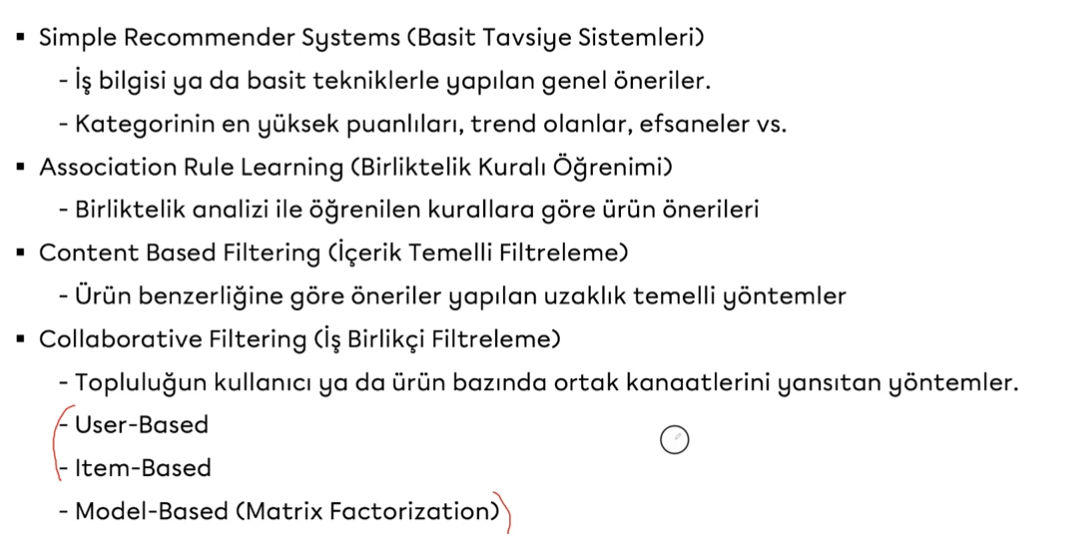

## Association Rule Learning (Birliktelik Kuralı Öğrenimi)
- Veri içerisindeki örüntüleri bulmak için kullanılan kural tabanlı bir makine öğrenmesi tekniğidir.
## Apriori Algoritması
- Sepet analizi yöntemidir. Ürün birlikteliklerini ortaya çıkarmak için kullanılır.
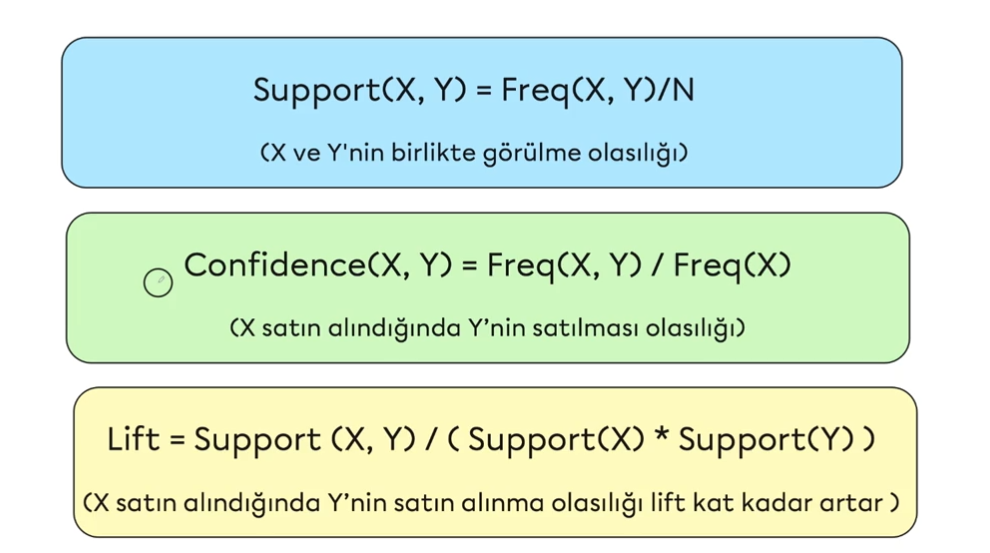

## Association Ruled Recommendation System
1. Veri Ön İşleme
2. ARL Veri Yapısını Hazırlama (Invoice-Prodcut Matrix)
3. Birliktelik Kurallarının Çıkarılması
4. Çalışmanın Scriptini Hazırlama
5. Sepet Aşamasındaki Kullanıcalara Ürün Önerisinde Bulunmak

1. Veri Ön İşleme

In [1]:
!pip install mlxtend

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)

In [3]:
df_ = pd.read_excel("C:/recommender/datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe.loc[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"]>0]
    dataframe = dataframe[dataframe["Price"]>0]
    return dataframe

df = retail_data_prep(df)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0,12.988208,179.331551,1.000,2.00,6.00,12.00,80995.00
Price,397885.0,3.116525,22.097861,0.001,1.25,1.95,3.75,8142.75
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


In [5]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [6]:
df = df_.copy()
df.shape

(541910, 8)

In [7]:
def outlier_threshold(dataframe, variable, q1=.01, q3=.99):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe[variable] = dataframe[variable].apply(
        lambda x: up_limit if x > up_limit else (low_limit if x < low_limit else x))
    
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe.loc[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"]>0]
    dataframe = dataframe[dataframe["Price"]>0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

df = retail_data_prep(df)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397885.0,11.830770,25.523052,1.000,2.00,6.00,12.00,298.50
Price,397885.0,2.893492,3.227175,0.001,1.25,1.95,3.75,37.06
Customer ID,397885.0,15294.416882,1713.144421,12346.000,13969.00,15159.00,16795.00,18287.00


2. ARL Veri Yapısını Hazırlama (Invoice-Prodcut Matrix)

In [52]:
df_fr = df[df["Country"]=="France"]
df_fr.shape

(8342, 8)

In [53]:
df_fr.groupby(["Invoice", "Description"]).agg({"Quantity": "sum"}).head(20)

Quantity
Invoice Description                                  
536370   SET 2 TEA TOWELS I LOVE LONDON          24.0
        ALARM CLOCK BAKELIKE GREEN               12.0
        ALARM CLOCK BAKELIKE PINK                24.0
        ALARM CLOCK BAKELIKE RED                 24.0
        CHARLOTTE BAG DOLLY GIRL DESIGN          20.0
        CIRCUS PARADE LUNCH BOX                  24.0
        INFLATABLE POLITICAL GLOBE               48.0
        LUNCH BOX I LOVE LONDON                  24.0
        MINI JIGSAW CIRCUS PARADE                24.0
        MINI JIGSAW SPACEBOY                     24.0
        MINI PAINT SET VINTAGE                   36.0
        PANDA AND BUNNIES STICKER SHEET          12.0
        POSTAGE                                   3.0
        RED TOADSTOOL LED NIGHT LIGHT            24.0
        ROUND SNACK BOXES SET OF4 WOODLAND       24.0
        SET/2 RED RETROSPOT TEA TOWELS           18.0
        SPACEBOY LUNCH BOX                       24.0
        STARS GIFT TAPE                          24.0
        VINTAGE HEADS AND TAILS CARD GAME        24.0
        VINTAGE SEASIDE JIGSAW PUZZLES           12.0

In [54]:
df_fr.groupby(["Invoice", "Description"]).agg({"Quantity": "sum"}).unstack().iloc[0:5, 0:5]

Quantity                                                                                                          
Description  50'S CHRISTMAS GIFT BAG LARGE  DOLLY GIRL BEAKER  I LOVE LONDON MINI BACKPACK  NINE DRAWER OFFICE TIDY  SET 2 TEA TOWELS I LOVE LONDON 
Invoice                                                                                                                                             
536370                                 NaN                NaN                          NaN                      NaN                             24.0
536852                                 NaN                NaN                          NaN                      NaN                              NaN
536974                                 NaN                NaN                          NaN                      NaN                              NaN
537065                                 NaN                NaN                          NaN                      NaN                              NaN
537463                                 NaN                NaN                          NaN                      NaN                              NaN

In [55]:
df_fr.groupby(["Invoice", "Description"]).agg({"Quantity": "sum"}).unstack().fillna(0).iloc[0:5, 0:5]

Quantity                                                                                                          
Description  50'S CHRISTMAS GIFT BAG LARGE  DOLLY GIRL BEAKER  I LOVE LONDON MINI BACKPACK  NINE DRAWER OFFICE TIDY  SET 2 TEA TOWELS I LOVE LONDON 
Invoice                                                                                                                                             
536370                                 0.0                0.0                          0.0                      0.0                             24.0
536852                                 0.0                0.0                          0.0                      0.0                              0.0
536974                                 0.0                0.0                          0.0                      0.0                              0.0
537065                                 0.0                0.0                          0.0                      0.0                              0.0
537463                                 0.0                0.0                          0.0                      0.0                              0.0

In [12]:
df_fr.groupby(["Invoice", "Description"]).agg({"Quantity": "sum"}).unstack().fillna(0).applymap(lambda x: 1 if x>0 else 0).iloc[0:5, 0:5]

Quantity                                                                                                          
Description  50'S CHRISTMAS GIFT BAG LARGE  DOLLY GIRL BEAKER  I LOVE LONDON MINI BACKPACK  NINE DRAWER OFFICE TIDY  SET 2 TEA TOWELS I LOVE LONDON 
Invoice                                                                                                                                             
536370                                   0                  0                            0                        0                                1
536852                                   0                  0                            0                        0                                0
536974                                   0                  0                            0                        0                                0
537065                                   0                  0                            0                        0                                0
537463                                   0                  0                            0                        0                                0

In [13]:
df_fr.groupby(["Invoice", "StockCode"]).agg({"Quantity": "sum"}).unstack().fillna(0).applymap(lambda x: 1 if x>0 else 0)

Quantity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [22]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

fr_inv_pro_df = create_invoice_product_df(df_fr)
fr_inv_pro_df.head()

Description   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   NINE DRAWER OFFICE TIDY   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET   TRELLIS COAT RACK  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  12 EGG HOUSE PAINTED WOOD  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  12 PENCILS TALL TUBE WOODLAND  15CM CHRISTMAS GLASS BALL 20 LIGHTS  16 PIECE CUTLERY SET PANTRY DESIGN  18PC WOODEN CUTLERY SET DISPOSABLE  20 DOLLY PEGS RETROSPOT  200 RED + WHITE BENDY STRAWS  3 HOOK HANGER MAGIC GARDEN  3 PIECE SPACEBOY COOKIE CUTTER SET  3 RAFFIA RIBBONS 50'S CHRISTMAS   3 STRIPEY MICE FELTCRAFT  3 TIER CAKE TIN RED AND CREAM  3 TRADITIONAl BISCUIT CUTTERS  SET  36 DOILIES DOLLY GIRL  36 DOILIES VINTAGE CHRISTMAS  36 FOIL HEART CAKE CASES  36 FOIL STAR CAKE CASES   36 PENCILS TUBE RED RETROSPOT  36 PENCILS TUBE SKULLS  36 PENCILS TUBE WOODLAND  3D HEARTS  HONEYCOMB PAPER GARLAND  3D TRADITIONAL CHRISTMAS STICKERS  3D VINTAGE CHRISTMAS STICKERS   4 IVORY DINNER CANDLES SILVER FLOCK  4 PINK DINNER CANDLE SILVER FLOCK  4 TRADITIONAL SPINNING TOPS  5 HOOK HANGER MAGIC TOADSTOOL  5 HOOK HANGER RED MAGIC TOADSTOOL  6 GIFT TAGS 50'S CHRISTMAS   6 GIFT TAGS VINTAGE CHRISTMAS   6 RIBBONS EMPIRE    6 RIBBONS RUSTIC CHARM  6 ROCKET BALLOONS   60 CAKE CASES DOLLY GIRL DESIGN  60 CAKE CASES VINTAGE CHRISTMAS  60 TEATIME FAIRY CAKE CASES  6PC WOOD PLATE SET DISPOSABLE  72 SWEETHEART FAIRY CAKE CASES  A PRETTY THANK YOU CARD  ABC TREASURE BOOK BOX   ADULT APRON APPLE DELIGHT  ADVENT CALENDAR GINGHAM SACK  AGED GLASS SILVER T-LIGHT HOLDER  AIRLINE BAG VINTAGE JET SET BROWN  AIRLINE BAG VINTAGE JET SET RED  AIRLINE BAG VINTAGE JET SET WHITE  AIRLINE BAG VINTAGE TOKYO 78  AIRLINE BAG VINTAGE WORLD CHAMPION   AIRLINE LOUNGE,METAL SIGN  ALARM CLOCK BAKELIKE CHOCOLATE  ALARM CLOCK BAKELIKE GREEN  ALARM CLOCK BAKELIKE IVORY  ALARM CLOCK BAKELIKE ORANGE  ALARM CLOCK BAKELIKE PINK  ALARM CLOCK BAKELIKE RED   ALPHABET HEARTS STICKER SHEET  ALUMINIUM STAMPED HEART  AMETHYST CHUNKY BEAD BRACELET W STR  ANGEL DECORATION STARS ON DRESS  ANTIQUE ALL GLASS CANDLESTICK  ANTIQUE GLASS DRESSING TABLE POT  ANTIQUE GLASS PEDESTAL BOWL  ANTIQUE SILVER BAUBLE LAMP    ANTIQUE SILVER T-LIGHT GLASS  ANTIQUE SILVER TEA GLASS ENGRAVED  APPLE BATH SPONGE  AREA PATROLLED METAL SIGN  ASS COLOUR GLOWING TIARAS  ASS FLORAL PRINT MULTI SCREWDRIVER  ASSORTED BOTTLE TOP  MAGNETS   ASSORTED COLOUR BIRD ORNAMENT  ASSORTED COLOUR MINI CASES  ASSORTED COLOUR T-LIGHT HOLDER  ASSORTED COLOURS SILK FAN  ASSORTED EASTER DECORATIONS  BELLS  ASSORTED EASTER GIFT TAGS  ASSORTED FLOWER COLOUR "LEIS"  ASSORTED TUTTI FRUTTI BRACELET  ASSORTED TUTTI FRUTTI MIRROR  ASSORTED TUTTI FRUTTI SMALL PURSE  ASSTD DESIGN 3D PAPER STICKERS  ASSTD DESIGN RACING CAR PEN  ASSTD FRUIT+FLOWERS FRIDGE MAGNETS  ASSTD RASTA KEY-CHAINS  BABUSHKA LIGHTS STRING OF 10  BAG 125g SWIRLY MARBLES  BAG 250g SWIRLY MARBLES  BAKING MOULD CHOCOLATE CUPCAKES  BAKING MOULD EASTER EGG MILK CHOC  BAKING MOULD EASTER EGG WHITE CHOC  BAKING MOULD HEART MILK CHOCOLATE  BAKING MOULD HEART WHITE CHOCOLATE  BAKING SET 9 PIECE RETROSPOT   BAKING SET SPACEBOY DESIGN  BALLOON ART MAKE YOUR OWN FLOWERS  BALLOON PUMP WITH 10 BALLOONS  BALLOON WATER BOMB PACK OF 35  BALLOONS  WRITING SET   BANQUET BIRTHDAY  CARD    BASKET OF TOADSTOOLS  BATH BUILDING BLOCK WORD  BEADED CRYSTAL HEART BLUE  LARGE  BELLE JARDINIERE CUSHION COVER  BEWARE OF THE CAT METAL SIGN   BIG DOUGHNUT FRIDGE MAGNETS  BILI NUT AND WOOD NECKLACE  BINGO SET  BIRD DECORATION GREEN POLKADOT  BIRD DECORATION RED RETROSPOT  BIRD HOUSE HOT WATER BOTTLE  BIRDS MOBILE VINTAGE DESIGN  BIRTHDAY CARD, RETRO SPOT  BISCUIT TIN 50'S CHRISTMAS  BISCUIT TIN VINTAGE CHRISTMAS  BISCUIT TIN VINTAGE GREEN  BISCUIT TIN VINTAGE RED  BLACK AND WHITE CAT BOWL  BLACK CANDELABRA T-LIGHT HOLDER  BLACK CHRISTMAS TR

In [23]:
fr_inv_pro_df = create_invoice_product_df(df_fr, True)
fr_inv_pro_df.head()

StockCode,10002,10120,10125,10135,11001,15036,15039,16012,16048,16218,16219,16225,16236,16237,16238,17174,20615,20617,20658,20665,20668,20674,20675,20676,20677,20679,20681,20682,20684,20685,20686,20702,20704,20711,20712,20713,20717,20718,20719,20723,20724,20725,20726,20727,20728,20749,20750,20751,20767,20777,20819,20832,20866,20914,20961,20963,20966,20967,20971,20972,20973,20974,20975,20977,20978,20979,20981,20983,20984,20992,20996,21012,21026,21027,21030,21034,21035,21039,21042,21054,21055,21056,21058,21059,21061,21062,21063,21064,21065,21068,21069,21070,21078,21080,21084,21086,21087,21088,21090,21094,21095,21096,21098,21108,21110,21111,21114,21116,21121,21122,21123,21124,21125,21126,21135,21136,21137,21154,21155,21156,21161,21162,21163,21164,21165,21166,21174,21175,21181,21188,21194,21195,21196,21197,21198,21199,21200,21201,21202,21204,21205,21206,21207,21208,21209,21210,21212,21213,21216,21217,21218,21219,21221,21224,21231,21232,21238,21239,21240,21242,21243,21244,21245,21246,21248,21249,21251,21257,21258,21259,21262,21284,21286,21294,21306,21326,21328,21329,21340,21351,21354,21355,21356,21358,21361,21365,21369,21371,21372,21374,21375,21377,21380,21381,21383,21385,21394,21395,21398,21399,21402,21403,21407,21408,21411,21424,21425,21426,21427,21428,21429,21430,21439,21442,21452,21463,21466,21467,21469,21470,21471,21472,21479,21481,21484,21485,21494,21495,21497,21498,21499,21500,21506,21507,21508,21509,21519,21523,21524,21527,21528,21531,21533,21535,21537,21539,21544,21555,21556,21557,21558,21559,21561,21563,21564,21576,21577,21578,21579,21581,21584,21591,21621,21622,21623,21624,21643,21648,21650,21658,21668,21669,21671,21672,21673,21675,21677,21678,21679,21680,21693,21696,21698,21700,21703,21704,21706,21707,21708,21709,21710,21711,21715,21716,21719,21721,21723,21724,21725,21731,21733,21739,21746,21747,21749,21754,21755,21756,21770,21774,21786,21787,21790,21791,21812,21813,21818,21819,21821,21828,21829,21832,21833,21843,21844,21845,21864,21865,21866,21871,21872,21875,21877,21880,21881,21882,21883,21884,21888,21889,21890,21891,21892,21894,21900,21901,21905,21906,21907,21908,21912,21913,21914,21915,21916,21917,21918,21922,21926,21928,21929,21930,21931,21932,21933,21934,21935,21936,21937,21943,21946,21947,21948,21949,21955,21967,21972,21974,21975,21976,21977,21980,21981,21982,21983,21985,21986,21987,21988,21989,21990,22023,22024,22025,22026,22027,22028,22029,22032,22035,22037,22041,22043,22044,22045,22046,22051,22052,22059,22063,22064,22065,22068,22070,22071,22072,22073,22076,22077,22078,22079,22080,22081,22082,22083,22084,22085,22086,22087,22088,22089,22090,22091,22093,22094,22099,22109,22110,22111,22112,22113,22114,22115,22116,22118,22120,22121,22124,22129,22130,22131,22132,22133,22134,22136,22138,22139,22141,22142,22144,22149,22150,22151,22153,22170,22174,22175,22176,22178,22179,22180,22181,22189,22191,22192,22193,22195,22197,22198,22199,22200,22203,22204,22207,22208,22209,22210,22211,22215,22219,22221,22222,22223,22224,22228,22231,22232,22236,22242,22243,22244,22254,22255,22262,22264,22269,22271,22272,22273,22274,22282,22285,22294,22295,22299,22300,22301,22302,22303,22305,22306,22309,22311,22312,22313,22314,22315,22318,22319,22320,22321,22322,22324,22325,22326,22327,22328,22329,22331,22332,22333,22334,22339,22340,22341,22343,22344,22346,22348,22349,22350,22352,22354,22355,22356,22357,22358,22361,22362,22365,22366,22367,22371,22372,22374,22375,22376,22377,22378,22379,22380,22381,22382,22383,22384,22385,22386,22389,22390,22393,22394,22396,22398,22399,22400,22402,22403,22406,22408,22411,22412,22413,22414,22416,22417,22418,22419,22422,22423,22425,22427,22431,22432,22433,22434,22435,22436,22437,22438,22439,22440,22443,22444,22445,22449,22451,22452,22453,22454,22456,22457,22459,22466,22467,22468,22469,22471,22472,22474,22475,22480,22482,22483,22485,22489,22491,22492,22493,22495,22498,22499,22500,22501,22502,22504,22505,22507,22508,22514,22515,22516,22517,22518,22519,22520,22521,22522,22523,22524,22525,22526,22529,22530,22531,22532,

In [24]:
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"]==stock_code][["Description"]].values[0].tolist()
    print(product_name)
    
check_id(df_fr, 10002)

['INFLATABLE POLITICAL GLOBE ']


3. Birliktelik Kurallarının Çıkarılması

In [25]:
frequent_itemset = apriori(fr_inv_pro_df, min_support=0.01, use_colnames=True)
frequent_itemset.sort_values("support", ascending=False)

C:\Users\suley\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
538,0.773779,(POST)
387,0.187661,(23084)
107,0.179949,(21731)
243,0.172237,(22554)
245,0.169666,(22556)
...,...,...
18793,0.010283,"(22729, 21086, 22326, 22551)"
18787,0.010283,"(23256, 21086, 22492, 22326)"
18786,0.010283,"(22728, 21086, 22492, 22326)"
18785,0.010283,"(21086, 22492, 22326, 22727)"


In [26]:
rules = association_rules(frequent_itemset, metric="support", min_threshold=0.01)

In [27]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(10002),(21791),0.020566,0.028278,0.010283,0.500000,17.681818,0.009701,1.943445
1,(21791),(10002),0.028278,0.020566,0.010283,0.363636,17.681818,0.009701,1.539111
2,(10002),(21915),0.020566,0.069409,0.010283,0.500000,7.203704,0.008855,1.861183
3,(21915),(10002),0.069409,0.020566,0.010283,0.148148,7.203704,0.008855,1.149771
4,(10002),(22551),0.020566,0.136247,0.010283,0.500000,3.669811,0.007481,1.727506
...,...,...,...,...,...,...,...,...,...
1372699,(23254),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.071979,0.010283,0.010283,0.142857,13.892857,0.009543,1.154670
1372700,(22326),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.159383,0.010283,0.010283,0.064516,6.274194,0.008644,1.057974
1372701,(21558),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.051414,0.010283,0.010283,0.200000,19.450000,0.009754,1.237147
1372702,(23291),"(22659, 23206, 22726, 22727, 22728, 20750, 223...",0.041131,0.010283,0.010283,0.250000,24.312500,0.009860,1.319623


In [28]:
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1606,(21080),(21086),0.133676,0.138817,0.102828,0.769231,5.541311,0.084271,3.731791
1607,(21086),(21080),0.138817,0.133676,0.102828,0.740741,5.541311,0.084271,3.341535
1608,(21080),(21094),0.133676,0.128535,0.102828,0.769231,5.984615,0.085646,3.776350
1609,(21094),(21080),0.128535,0.133676,0.102828,0.800000,5.984615,0.085646,4.331620
1776,(21086),(21094),0.138817,0.128535,0.123393,0.888889,6.915556,0.105550,7.843188
...,...,...,...,...,...,...,...,...,...
213940,"(POST, 22727)","(22728, 22726)",0.089974,0.074550,0.059126,0.657143,8.814778,0.052418,2.699229
213941,"(22726, 22727)","(22728, POST)",0.079692,0.092545,0.059126,0.741935,8.017025,0.051751,3.516388
213942,(22728),"(POST, 22726, 22727)",0.102828,0.074550,0.059126,0.575000,7.712931,0.051460,2.177529
213944,(22726),"(22728, POST, 22727)",0.097686,0.069409,0.059126,0.605263,8.720273,0.052346,2.357498


In [29]:
check_id(df_fr, 21080)

['SET/20 RED RETROSPOT PAPER NAPKINS ']


In [30]:
check_id(df_fr, 21086)

['SET/6 RED SPOTTY PAPER CUPS']


In [31]:
rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)].sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
23707,"(21080, 21094)",(21086),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301
23706,"(21080, 21086)",(21094),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
108820,"(21080, POST, 21086)",(21094),0.084833,0.128535,0.082262,0.969697,7.544242,0.071358,28.758355
108822,"(21080, POST, 21094)",(21086),0.084833,0.138817,0.082262,0.969697,6.985410,0.070486,28.419023
1777,(21094),(21086),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563
...,...,...,...,...,...,...,...,...,...
7212,(22629),(22630),0.125964,0.100257,0.071979,0.571429,5.699634,0.059351,2.099400
62249,(22630),"(POST, 22629)",0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62244,"(POST, 22629)",(22630),0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62248,(22629),"(POST, 22630)",0.125964,0.074550,0.053985,0.428571,5.748768,0.044594,1.619537


4. Çalışmanın Scriptini Hazırlama

In [32]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe


def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)


def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0].tolist()
    print(product_name)


def create_rules(dataframe, id=True, country="France"):
    dataframe = dataframe[dataframe['Country'] == country]
    dataframe = create_invoice_product_df(dataframe, id)
    frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
    return rules

df = df_.copy()

df = retail_data_prep(df)
rules = create_rules(df)

rules[(rules["support"]>0.05) & (rules["confidence"]>0.1) & (rules["lift"]>5)]. \
sort_values("confidence", ascending=False)

C:\Users\suley\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
23707,"(21080, 21094)",(21086),0.102828,0.138817,0.100257,0.975000,7.023611,0.085983,34.447301
23706,"(21080, 21086)",(21094),0.102828,0.128535,0.100257,0.975000,7.585500,0.087040,34.858612
108820,"(21080, POST, 21086)",(21094),0.084833,0.128535,0.082262,0.969697,7.544242,0.071358,28.758355
108822,"(21080, POST, 21094)",(21086),0.084833,0.138817,0.082262,0.969697,6.985410,0.070486,28.419023
1777,(21094),(21086),0.128535,0.138817,0.123393,0.960000,6.915556,0.105550,21.529563
...,...,...,...,...,...,...,...,...,...
7212,(22629),(22630),0.125964,0.100257,0.071979,0.571429,5.699634,0.059351,2.099400
62249,(22630),"(POST, 22629)",0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62244,"(POST, 22629)",(22630),0.100257,0.100257,0.053985,0.538462,5.370809,0.043933,1.949443
62248,(22629),"(POST, 22630)",0.125964,0.074550,0.053985,0.428571,5.748768,0.044594,1.619537


5. Sepet Aşamasındaki Kullanıcılara Ürün Önerisinde Bulunmak
- Örnek: Kullanıcı örnek ürün id: 22492

In [44]:
product_id = 22492
check_id(df, product_id)

['MINI PAINT SET VINTAGE ']


In [45]:
sorted_rules = rules.sort_values("lift", ascending=False)
sorted_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1082358,"(22659, 23206, 22726, 22727)","(21558, 23254, 22326, 23199)",0.010283,0.010283,0.010283,1.000000,97.250000,0.010177,inf
254690,"(21558, 23254, 20750)","(22352, 23291)",0.010283,0.010283,0.010283,1.000000,97.250000,0.010177,inf
1163665,"(21558, 23254, 22726, 20750)","(22727, 22352, 22326, 23291, 23199)",0.010283,0.010283,0.010283,1.000000,97.250000,0.010177,inf
1163666,"(23291, 23254, 22726, 20750)","(22727, 22352, 21558, 22326, 23199)",0.010283,0.010283,0.010283,1.000000,97.250000,0.010177,inf
973889,"(23206, 22728, 20750, 22326, 23254)","(22659, 21558, 22727)",0.010283,0.010283,0.010283,1.000000,97.250000,0.010177,inf
...,...,...,...,...,...,...,...,...,...
2744,(POST),(21535),0.773779,0.028278,0.010283,0.013289,0.469949,-0.011598,0.984810
25539,(21080),"(23084, POST)",0.133676,0.167095,0.010283,0.076923,0.460355,-0.012054,0.902314
25538,"(23084, POST)",(21080),0.167095,0.133676,0.010283,0.061538,0.460355,-0.012054,0.923132
1742,(21080),(23084),0.133676,0.187661,0.010283,0.076923,0.409905,-0.014803,0.880034


In [47]:
recommendation_list = []
for i, product in enumerate(sorted_rules["antecedents"]):
    for j in list(product):
        if j == product_id:
            recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

recommendation_list[0:3]

[22326, 22556, 22551]

In [48]:
check_id(df, 22326)

['ROUND SNACK BOXES SET OF4 WOODLAND ']


In [49]:
check_id(df, 22556)

['PLASTERS IN TIN CIRCUS PARADE ']


In [50]:
check_id(df, 22551)

['PLASTERS IN TIN SPACEBOY']


In [51]:
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[0])

    return recommendation_list[0:rec_count]


arl_recommender(rules, 22492, 1)
arl_recommender(rules, 22492, 2)
arl_recommender(rules, 22492, 3)

[22326, 22556, 22551]